In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib
from sklearn.cluster import KMeans
from skimage import filters, color
from skimage import data
from skimage.filters import threshold_multiotsu
from skimage import exposure

root_path = "/content/drive/MyDrive/AI project/Brain_Segmentation/png_output_local"
output_path = "/content/drive/MyDrive/AI project/Brain_Segmentation/png_preprocessed"

Mounted at /content/drive


# ***Preprocessing***

## Thresholding - Histogram Equalizer, Truncation, **CLAHE**

In [ ]:
anat_img_path = root_path + '/sub-C1_anat_sub-C1_acq_FLASH20_200um/sub-C1_acq_FLASH20_200um_slice200.png'
diff_img_path = root_path + '/sub-C1_dwi_sub-C1_dwi/sub-C1_dwi_slice120.png'

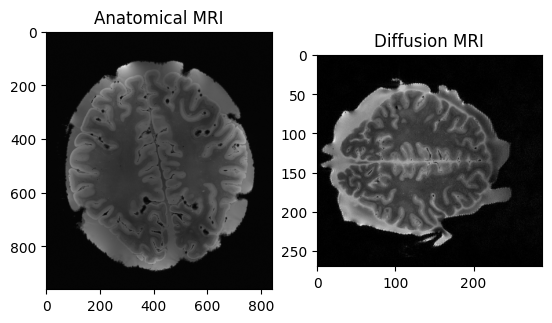

In [ ]:
'''
=============================================================================================================
Checking which MRI to use - Anatomical MRI fits the goal of segmenting GM, WM and CSF more than Diffusion MRI
=============================================================================================================
'''
titles = ['Anatomical MRI', 'Diffusion MRI']
anat_img = cv.imread(anat_img_path, cv.IMREAD_GRAYSCALE)
diff_img = cv.imread(diff_img_path, cv.IMREAD_GRAYSCALE)
images = [anat_img, diff_img]
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.title(titles[i])
  plt.imshow(images[i], cmap = "gray")

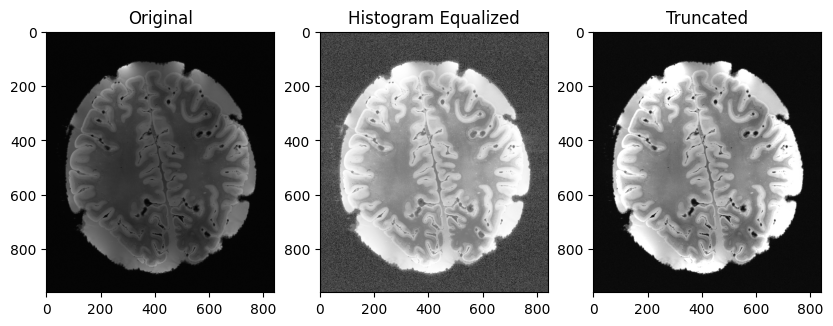

In [ ]:
'''
==============================================================
Applying simple Histogram equalizer and Truncated thresholding
==============================================================
'''
img = anat_img
eq_img = cv.equalizeHist(anat_img)
h = 110 #@param
ret,tr_img = cv.threshold(img,h,255,cv.THRESH_TRUNC)

titles = ['Original','Histogram Equalized','Truncated']
images = [img,eq_img,tr_img]
plt.figure(figsize=(10, 4))
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.title(titles[i])
  plt.imshow(images[i], cmap = "gray")


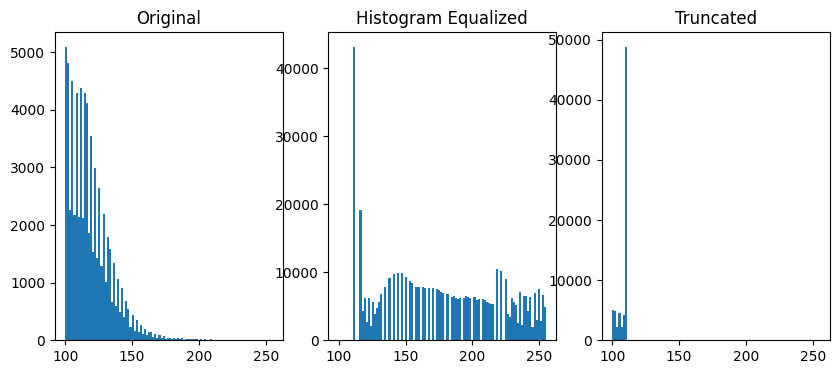

In [ ]:
'''
================================================
Checking the histogram of the images for balance
================================================
'''
titles = ['Original','Histogram Equalized','Truncated']
hists = [img.flat,eq_img.flat,tr_img.flat]
plt.figure(figsize=(10, 4))
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.title(titles[i])
  plt.hist(hists[i], bins=100, range=(100, 255))


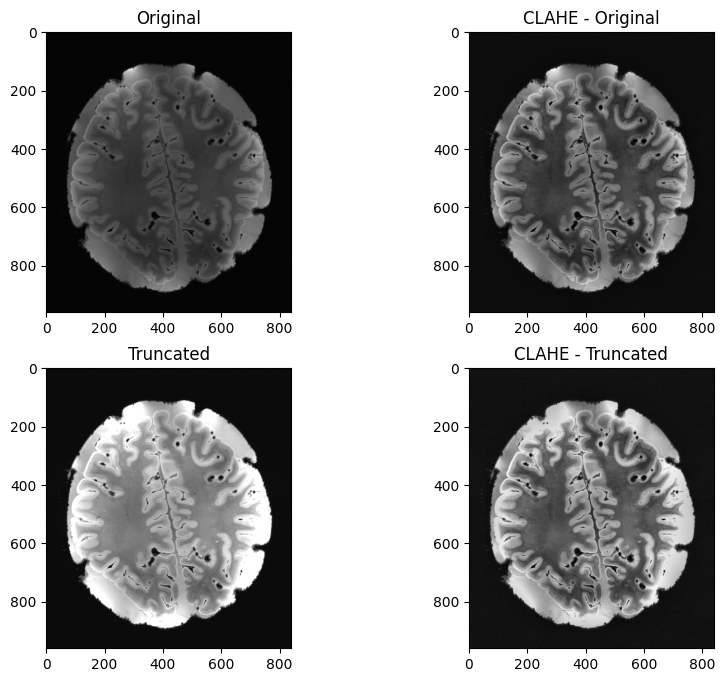

In [ ]:
'''
=================================================================================
Applying CLAHE (Contrast Limited Adaptive Histogram Equalization) to the original
and truncated MRI image. Simple HE, truncation work worse.
=================================================================================
'''
clahe = cv.createCLAHE(clipLimit =2.0, tileGridSize=(10,10))
cl_img = clahe.apply(img)
cl_tr_img = clahe.apply(tr_img)

images = [img,cl_img,tr_img,cl_tr_img]
titles = ['Original','CLAHE - Original','Truncated','CLAHE - Truncated']

plt.figure(figsize=(10, 8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(images[i], cmap='gray')
  plt.title(titles[i])

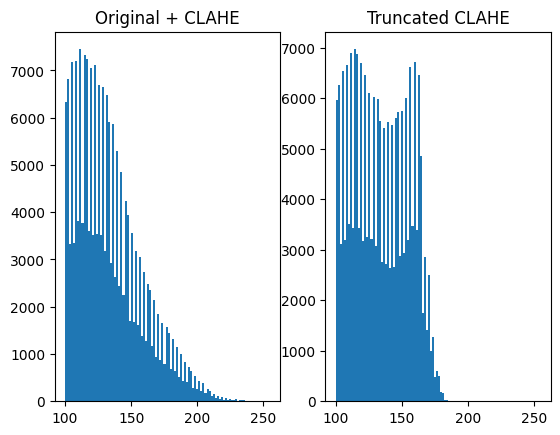

In [ ]:
'''
=========================================================
Histogram comparison of the original and truncated CLAHEs
=========================================================
'''
plt.subplot(121)
plt.title("Original + CLAHE")
plt.hist(cl_img.flat, bins=100, range=(100, 255))
plt.subplot(122)
plt.title("Truncated CLAHE")
plt.hist(cl_tr_img.flat, bins=100, range=(100, 255))
plt.show()

## Normalizing

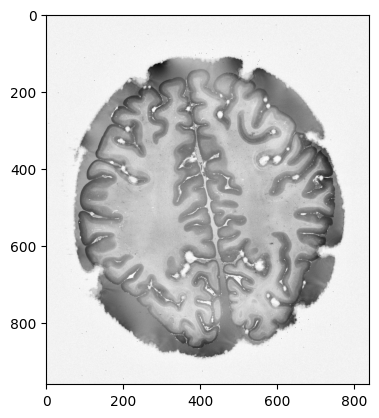

In [ ]:
# Normalize & Enhance Contrast
image = (cl_img - np.min(cl_img)) / (np.max(cl_img) - np.min(cl_img)) * 255
image = image.astype(np.uint8)
image_eq = (image * 255).astype(np.uint8)
plt.imshow(image_eq, cmap='gray')


## Denoising - **NLM**, Bilateral filtering

In [ ]:
'''
=======================================================
Non-local Means denoising (NLM) and bilateral filtering
=======================================================
'''
nlm_img = cv.fastNlMeansDenoising(cl_img, h = 10)
nlm_img2 = cv.fastNlMeansDenoising(cl_tr_img, h = 10)
bl_img = cv.bilateralFilter(cl_img, 9, 75, 75)

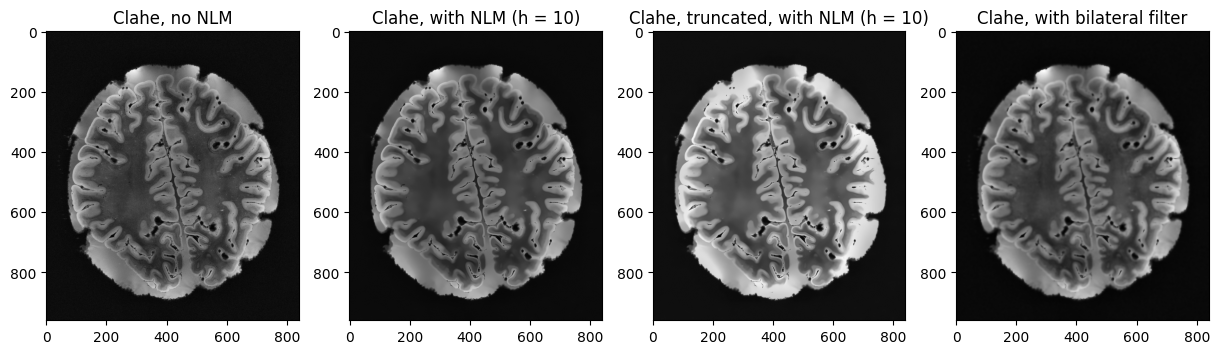

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.title("Clahe, no NLM")
plt.imshow(cl_img, cmap="gray")
plt.subplot(142)
plt.title("Clahe, with NLM (h = 10)")
plt.imshow(nlm_img, cmap="gray")
plt.subplot(143)
plt.title("Clahe, truncated, with NLM (h = 10)")
plt.imshow(nlm_img2, cmap="gray")
plt.subplot(144)
plt.title("Clahe, with bilateral filter")
plt.imshow(bl_img, cmap="gray")

In [ ]:
pixels = img.reshape(-1, 1)
pixels2 = cl_img.reshape(-1, 1)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(pixels)
segmented_img_bias = kmeans.labels_.reshape(img.shape)
kmeans.fit(pixels2)
segmented_img_clahe = kmeans.labels_.reshape(cl_img.shape)


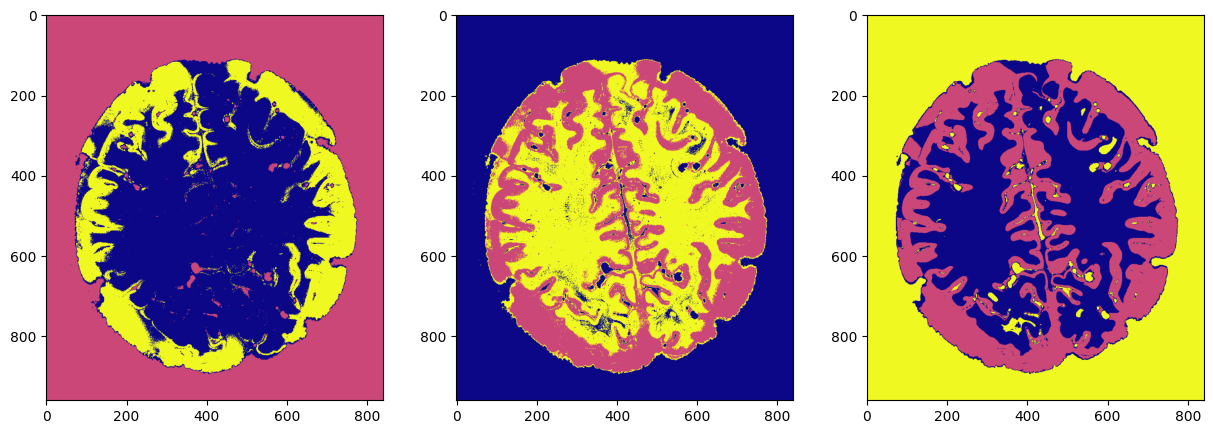

In [ ]:

nlm_img = cv.fastNlMeansDenoising(cl_img, h = 10)
pixels3 = nlm_img.reshape(-1, 1)
kmeans.fit(pixels3)
segmented_img_nlm = kmeans.labels_.reshape(nlm_img.shape)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("K-means after removing bias")
plt.imshow(segmented_img_bias, cmap='plasma')
plt.subplot(132)
plt.title("K-means after CLAHE")
plt.imshow(segmented_img_clahe, cmap='plasma')
plt.subplot(133)
plt.title("K-means after NLM")
plt.imshow(segmented_img_nlm, cmap='plasma')




# ***Segmenting***


## Multi-Otsu

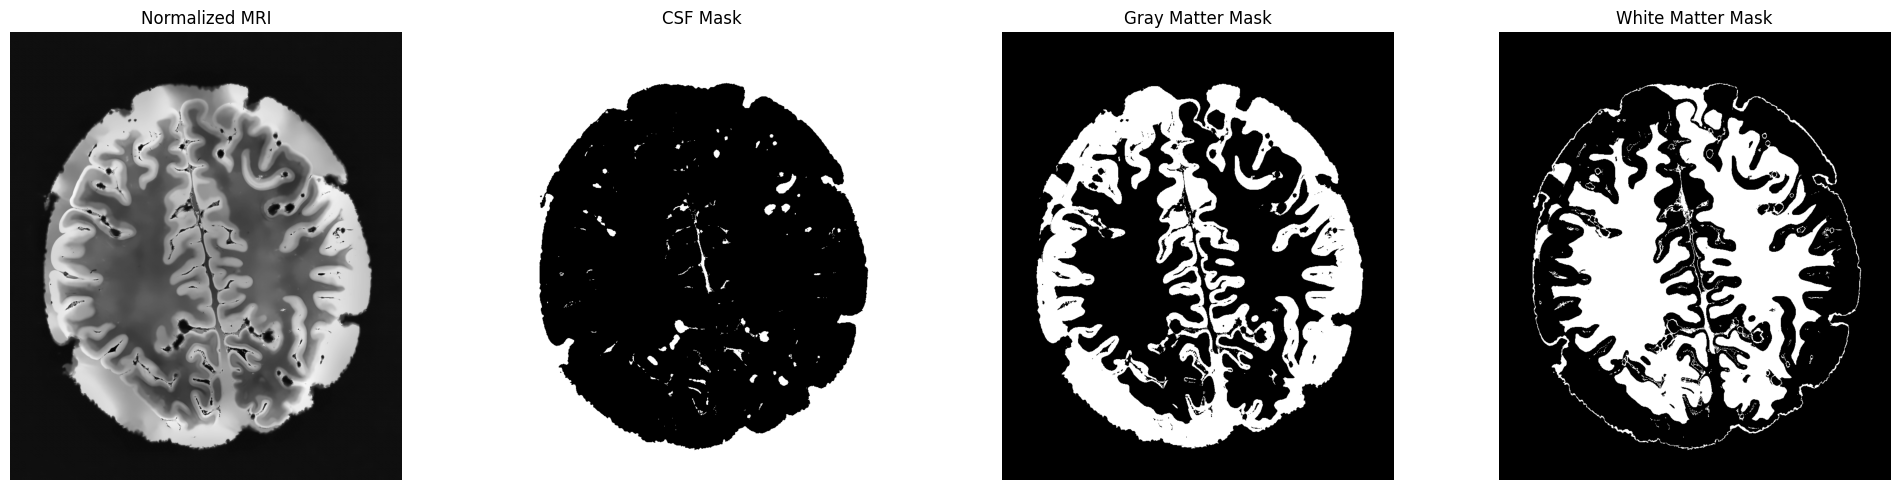

In [ ]:
# Load MRI image (grayscale)
img = nlm_img2

# Step 1: Normalize
norm = cv.normalize(img.astype('float32'), None, 0.0, 1.0, cv.NORM_MINMAX)

# Step 2: Multi-Otsu Thresholding
thresholds = filters.threshold_multiotsu(norm, classes=3)
regions = np.digitize(norm, bins=thresholds)

# Step 3: Map classes
# 0 - CSF (darkest), 1 - GM (mid), 2 - WM (brightest)
csf_mask = regions == 0
gm_mask = regions == 2
wm_mask = regions == 1

# Step 4: Visualize results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(norm, cmap='gray')
axes[0].set_title('Normalized MRI')
axes[0].axis('off')

axes[1].imshow(csf_mask, cmap='gray')
axes[1].set_title('CSF Mask')
axes[1].axis('off')

axes[2].imshow(gm_mask, cmap='gray')
axes[2].set_title('Gray Matter Mask')
axes[2].axis('off')

axes[3].imshow(wm_mask, cmap='gray')
axes[3].set_title('White Matter Mask')
axes[3].axis('off')

plt.tight_layout()
plt.show()


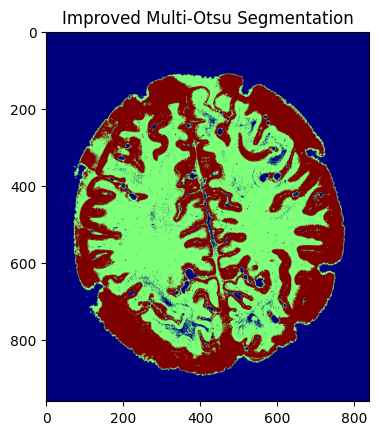

In [ ]:

thresholds = threshold_multiotsu(image, classes=3)
regions = np.digitize(image, bins=thresholds)

# Visualization
plt.imshow(regions, cmap='jet')
plt.title("Improved Multi-Otsu Segmentation")
plt.show()


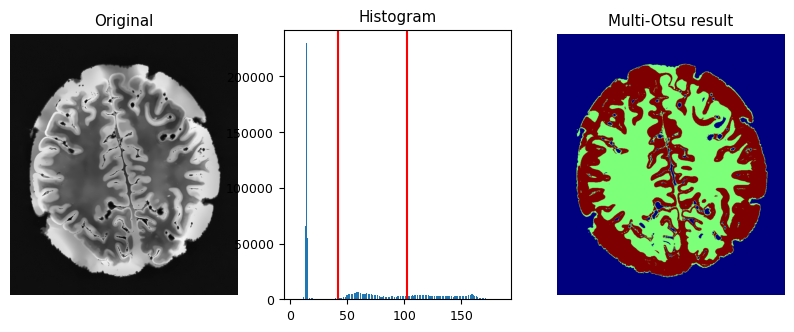

In [ ]:
# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = nlm_img2

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

## K-Means

In [ ]:


# Reshape image into a 1D array for clustering
pixels = cl_img.reshape(-1, 1)
pixels2 = nlm_img.reshape(-1,1)
pixels3 = nlm_img2.reshape(-1,1)
pixels4 = bl_img.reshape(-1,1)
# Apply K-Means with 3 clusters (black, gray, white)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10, algorithm='lloyd')
kmeans.fit(pixels)
segmented_img7 = kmeans.labels_.reshape(cl_img.shape)
kmeans.fit(pixels2)
segmented_img8 = kmeans.labels_.reshape(nlm_img.shape)
kmeans.fit(pixels3)
segmented_img9 = kmeans.labels_.reshape(nlm_img2.shape)
kmeans.fit(pixels4)
segmented_img10 = kmeans.labels_.reshape(bl_img.shape)


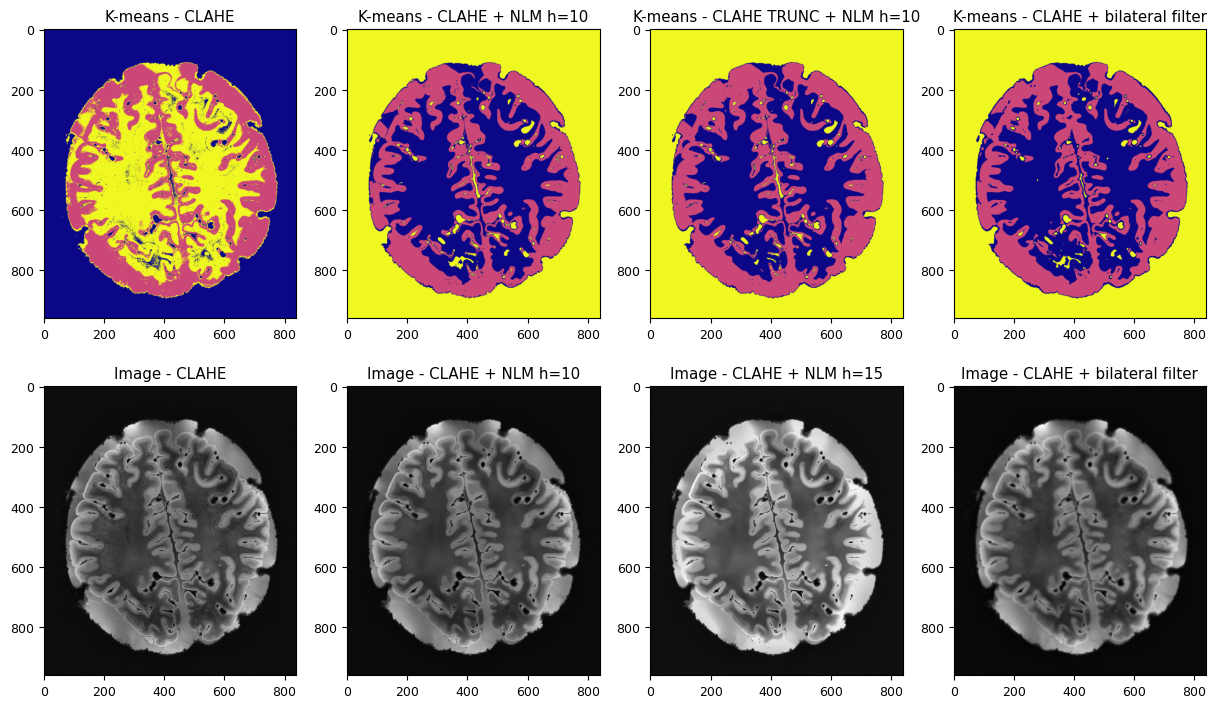

In [ ]:
titles = [
    'K-means - CLAHE',
    'K-means - CLAHE + NLM h=10',
    'K-means - CLAHE TRUNC + NLM h=10',
    'K-means - CLAHE + bilateral filter'
]

titles2 = [
    'Image - CLAHE',
    'Image - CLAHE + NLM h=10',
    'Image - CLAHE + NLM h=15',
    'Image - CLAHE + bilateral filter'
]

# Assume seg1, seg2, seg3 are your label maps (with values 0, 1, 2)
segmentations = [segmented_img7, segmented_img8, segmented_img9, segmented_img10]
images = [cl_img, nlm_img, nlm_img2, bl_img]

plt.figure(figsize=(15, 17))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.title(titles[i])
  plt.imshow(segmentations[i], cmap='plasma')
for i in range(4):
  plt.subplot(2,4,i+5)
  plt.title(titles2[i])
  plt.imshow(images[i], cmap='gray')

plt.show()

## Gaussian Mixture Models

---



In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(pixels)

segmented = gmm.predict(pixels)

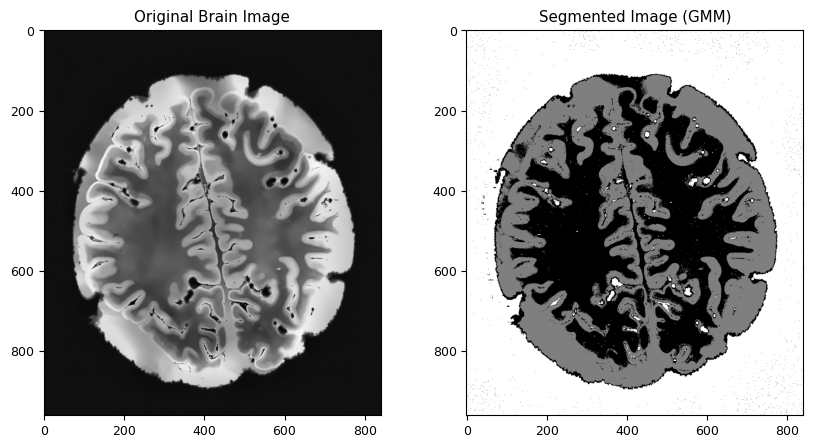

In [ ]:
# Reshape to original image shape
seg_img = segmented.reshape(cl_img.shape)

# Normalize labels to 0-255 for visualization
seg_img = (seg_img / seg_img.max() * 255).astype(np.uint8)

# Show original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Brain Image")
plt.imshow(img, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Segmented Image (GMM)")
plt.imshow(seg_img, cmap="gray")
plt.show()


In [ ]:
!pip install fcmeans

ERROR: Could not find a version that satisfies the requirement fcmeans (from versions: none)
ERROR: No matching distribution found for fcmeans


fatal: not a git repository (or any of the parent directories): .git
